In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [5]:
from qiskit import *

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_london')
backend_prop = backend.properties()
noise_model = NoiseModel.from_backend(backend)


# Setting up Readout Errors 
Error rates as per the London Noise Model

In [6]:
noise_model


NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'measure', 'id', 'u3', 'u2']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]

In [7]:
ReadoutError

qiskit.providers.aer.noise.errors.readout_error.ReadoutError

In [8]:
from  qiskit.providers.aer.noise.device.models import basic_device_readout_errors
from qiskit.providers.aer.noise.device import readout_error_values
readout_error_values(backend_prop)

[[0.0033333333333333335, 0.036666666666666625],
 [0.02, 0.050000000000000044],
 [0.23, 0.05666666666666664],
 [0.013333333333333308, 0.04666666666666667],
 [0.0033333333333333335, 0.046666666666666634]]

In [82]:
import numpy as np

mat_1 = [[1-0.003, 0.036], [0.003, 1-0.036]]
mat_2 = [[0.98, 0.05], [0.02, 0.95]]
# mat_3 = np.random.random((4,4))

# for r in range(len(mat_2)): 
#     for c in range(len(mat_2[r])):
#         most_sig_element = mat_2[c][r]
        
#         for i in range(len(mat_1)): 
#             for j in range(len(mat_1[i])):
#                 least_sig_element = mat_1[i][j]
                
#                 mat_3[2*r+i][2*c +j] = most_sig_element*least_sig_element
# mat_3

Need to tranpose to get in this format 

probabilities[0] = [P("0"|"0"), P("1"|"0")]

probabilities[1] = [P("0"|"1"), P("1"|"1")]

In [83]:
#transposing matrices 
mat_1 = np.transpose(mat_1)
mat_2 = np.transpose(mat_2)


In [85]:
mat = [mat_1, mat_2]

for matty in mat:
    #Making sure the sum of each row is one 
    for r in range(len(matty)): 
        #summing up all the elements of the row
        summ = 0
        for i in matty[r]:
            summ+=i

        #new row 
        n_row = []
        for i in matty[r]: 
            n_row.append(i/summ)

        #replacing the old row with fixed new row 
        matty[r] = n_row

In [88]:
mat[0]

array([[0.997, 0.003],
       [0.036, 0.964]])

In [89]:
mat[1]

array([[0.98, 0.02],
       [0.05, 0.95]])

In [87]:
#readout_error = ReadoutError(probabilities)
readout_error_1 = ReadoutError(mat[0])
readout_error_2 = ReadoutError(mat[1])

In [90]:
readout_error.number_of_qubits

1

# Creating the 18 noise models (9 with Readout errs and 9 w/n)

In [60]:
scales = [1,1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

In [91]:
from qiskit.providers.aer import noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

noise_models_pure = [] #w/n readout
noise_models_impure = [] # w/ readout

# First 9 without readout error
for i in scales: 
    # Depolarizing quantum errors
    new_prob_1 = i*prob_1
    new_prob_2 = i*prob_2
    
    #creating gate errors
    error_1 = noise.depolarizing_error(new_prob_1, 1)
    error_2 = noise.depolarizing_error(new_prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    #creating pure
    noise_models_pure.append(noise_model)
    
# Next 9 with readout error
for i in scales: 
    # Depolarizing quantum errors
    new_prob_1 = i*prob_1
    new_prob_2 = i*prob_2
    
    #creating gate errors
    error_1 = noise.depolarizing_error(new_prob_1, 1)
    error_2 = noise.depolarizing_error(new_prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    
    #now adding readout error 
    noise_model.add_readout_error(readout_error_1, [0])
    noise_model.add_readout_error(readout_error_2, [1])
    noise_models_impure.append(noise_model)

In [92]:
noise_models_impure[0]

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u1', 'measure', 'u3', 'u2']
  Qubits with noise: [0, 1]
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']
  Specific qubit errors: [('measure', [0]), ('measure', [1])]

# Example

In [97]:
noise_model = noise.NoiseModel()
noise_model.add_readout_error(readout_error, [0])
noise_model.add_readout_error(readout_error, [1])
    

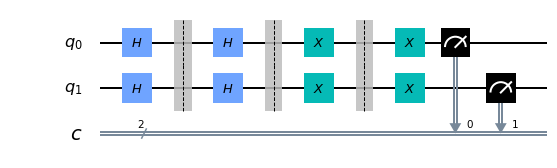

In [98]:
circ = QuantumCircuit(2,2)
circ.h(0)
circ.barrier(0)
circ.h(0)
circ.barrier(0)
circ.x(0)
circ.barrier(0)
circ.x(0)

circ.h(1)
circ.barrier(1)
circ.h(1)
circ.barrier(1)
circ.x(1)
circ.barrier(1)
circ.x(1)

circ.measure(0, 0)
circ.measure(1, 1)
circ.draw(output = 'mpl')

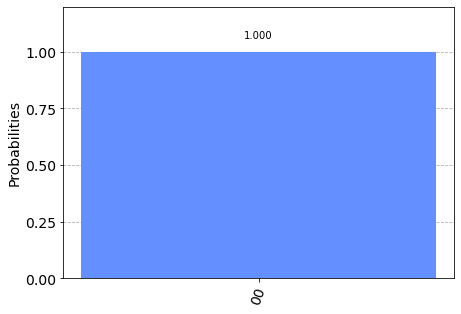

In [99]:
from qiskit.tools.visualization import plot_histogram

job = execute(circ, backend = simulator, shots = 1024)
counts = job.result().get_counts()
plot_histogram(counts)


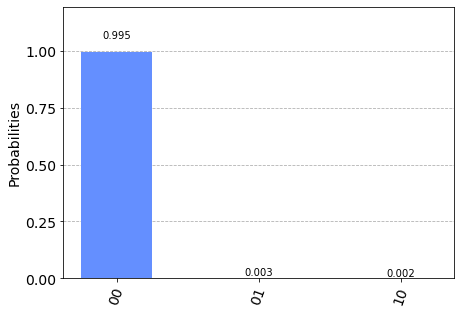

In [100]:
# machine= provider.get_backend('ibmq_london')
# noise_model = NoiseModel.from_backend(machine)

job = execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
counts = job.result().get_counts()
plot_histogram(counts)

## VQE Optimized Circuit 

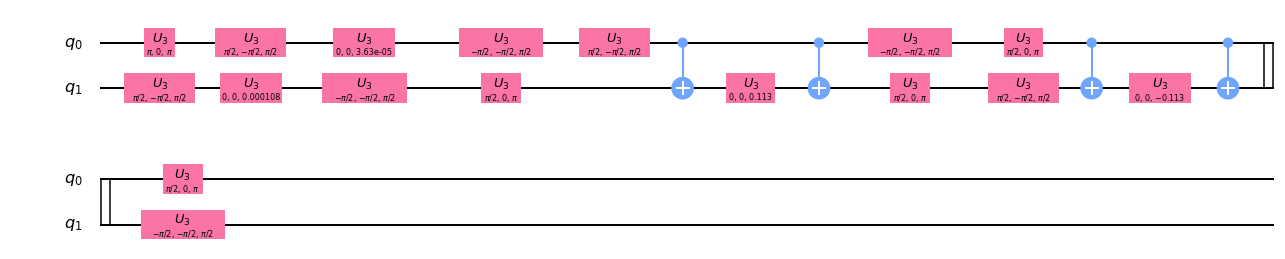

In [101]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
# vqe_circ.measure(0,0)
# vqe_circ.measure(1,1)
vqe_circ.draw(output = 'mpl')

## Hammyfication of Circuits

In [102]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [103]:
# because first 4 circuits are really the same thing (II, IZ, ZZ, ZI does not require any addition of gates for measurements)
less_circuits = [circuits[0], circuits[4]]

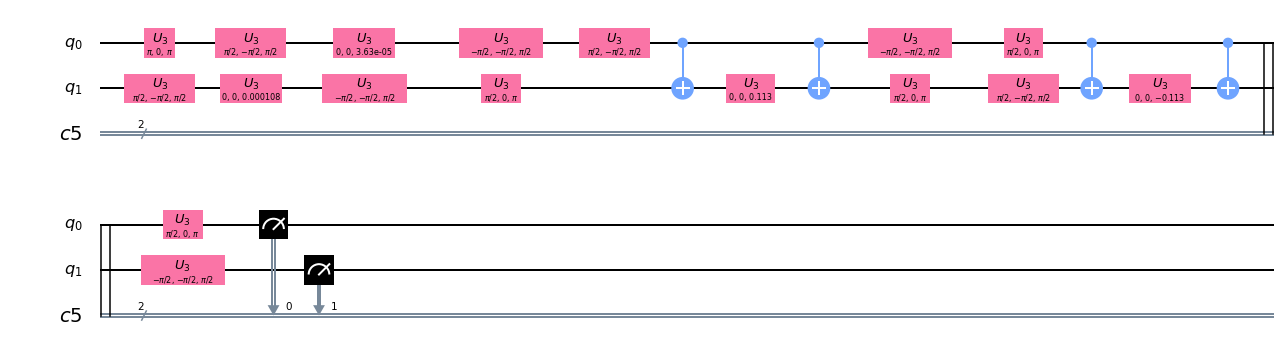

In [104]:
less_circuits[0].draw(output = 'mpl')

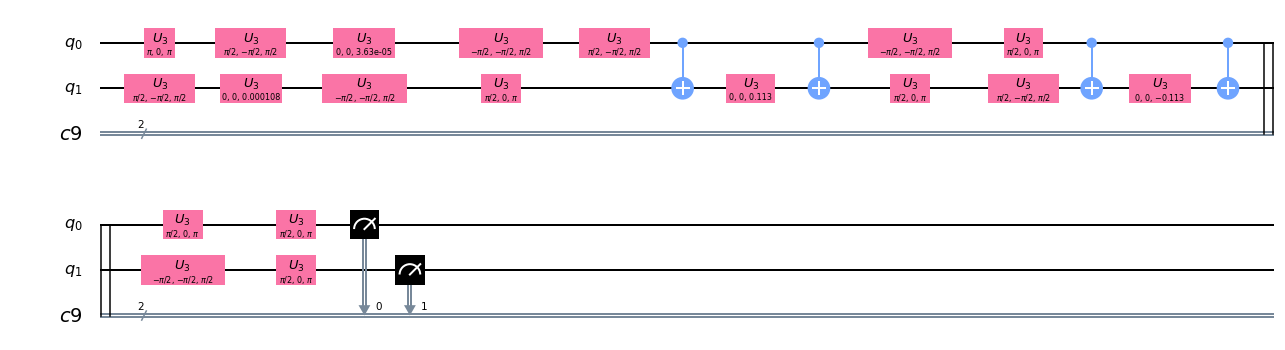

In [105]:
less_circuits[1].draw(output = 'mpl')

## Functions for computing Expectation value

In [106]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [107]:
def get_expec_val_H2(results, h, shots = 1024):
    keys = results.get_counts().keys()
    e_val = 0
    for key in keys:
        counts =int(results.get_counts()[key])
        
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(counts)/shots)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(counts)/shots)
            else:
                e_val += (-1)*(int(counts)/shots)
    return e_val
    

# Running the circuit on all 19 noise models (Ideal simulator, 18 noisy simulators)

In [108]:
from qiskit import Aer
simulator = Aer.get_backend('qasm_simulator')

### Function to evaluate circuits

In [109]:
def evaluator(circuits, noise_model = None, 
              weights =  [-1.053, 0.395, -0.395, -0.011, 0.181]):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = []
    for circ in circuits: 
        job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
        result = job.result()
        results.append(result)
    
    #Converting counts to expec values of local hammys
    
    n = 5 #if 5 hammys, then length is 5, 5th one is assumed to be XX
    hammyfied_vals = []
    for i in range(n): 
        if (i <4):
            c = 0
        else: 
            c= 1
        hammyfied_val = get_expec_val_H2(results[c], i)
        hammyfied_vals.append(hammyfied_val)
    
    #Combining expectation values of local hamiltonians with the weights and adding nuclear repulsion energy
    
    shift = 0.7151043390810812
    expec_val = 0 + shift
    for i in range(len(hammyfied_vals)): 
        expec_val += weights[i]*hammyfied_vals[i]
        
    return expec_val
    

In [110]:
from qiskit import Aer
simulator = Aer.get_backend('qasm_simulator')

In [111]:
n_samples = 1000

ideal_mean = 0
idea_err = 0
pure_means = []
impure_means = []
pure_errs = []
impure_errs = []

#Running Pure first
print('Running Pure first')

for nm in range(len(noise_models_pure)): 
    noise_model = noise_models_pure[nm]
    results = []
    for i in range(n_samples): 
#         # for tracking results 
#         if (i%25 == 0): 
#             print('---------'+str(i) + ' samples done--------------')
        result = evaluator(less_circuits, noise_model)
        results.append(result)
    mean = np.mean(results)
    err = np.std(results)/np.sqrt(len(results))
    pure_means.append(mean)
    pure_errs.append(err)
    print('---------'+str(nm) + ' models done--------------')

#impure next

print('Running ImPure next')
for nm in range(len(noise_models_impure)): 
    
    noise_model = noise_models_impure[nm]
    results = []
    for i in range(n_samples): 
#         # for tracking results 
#         if (i%25 == 0): 
#             print('---------'+str(i) + ' samples done--------------')
        result = evaluator(less_circuits, noise_model)
        results.append(result)
    mean = np.mean(results)
    err = np.std(results)/np.sqrt(len(results))
    impure_means.append(mean)
    impure_errs.append(err)
    print('---------'+str(nm) + ' models done--------------')

print('Running Ideal last')
#ideal sim last
results = []
for i in range(n_samples): 
#     # for tracking results 
#     if (i%25 == 0): 
#         print('---------'+str(i) + ' samples done--------------')
    result = evaluator(less_circuits)
    results.append(result)
ideal_mean = np.mean(results)
ideal_err = np.std(results)/np.sqrt(len(results))

        


Running Pure first
---------0 models done--------------
---------1 models done--------------
---------2 models done--------------
---------3 models done--------------
---------4 models done--------------
---------5 models done--------------
---------6 models done--------------
---------7 models done--------------
---------8 models done--------------
Running ImPure next
---------0 models done--------------
---------1 models done--------------
---------2 models done--------------
---------3 models done--------------
---------4 models done--------------
---------5 models done--------------
---------6 models done--------------
---------7 models done--------------
---------8 models done--------------
Running Ideal last


## Plotting Results

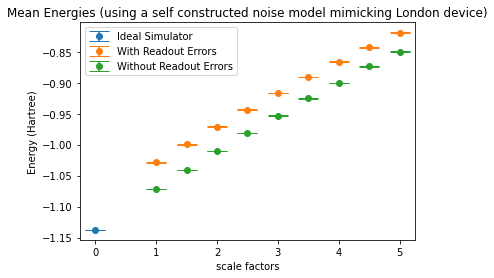

In [112]:
import matplotlib.pyplot as plt

f = plt.figure()
plt.errorbar(0, ideal_mean, yerr=ideal_err,capsize = 10, fmt ='o', label = 'Ideal Simulator' )
plt.errorbar(scales, impure_means, yerr=impure_errs,capsize = 10, fmt ='o', label = 'With Readout Errors' )
plt.errorbar(scales, pure_means, yerr=pure_errs,capsize = 10, fmt ='o', label = 'Without Readout Errors' )

plt.title('Mean Energies (using a self constructed noise model mimicking London device)')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()
f.savefig('1000sample.png', dpi = 1000)

In [98]:
ideal_mean

-1.137769098418919

In [99]:
pure_means

[-1.0727099187314189,
 -1.0424255242001688,
 -1.0092176726376687,
 -0.9811469890439186,
 -0.9513861296689189,
 -0.9269916570126688,
 -0.9007952898251689,
 -0.8778274187314188,
 -0.8489748992001688]